In [1]:
import torch
import torchvision
import DDIM
import DDPM
import SDE
from itertools import islice
import matplotlib.pyplot as plt


In [2]:
class CropCelebA64:
    def __call__(self, img):
        return img.crop((15, 40, 178 - 15, 218 - 30))

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
train_dataset = torchvision.datasets.CelebA(
    root='../VAE/celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale()
    ]),
)

test_dataset = torchvision.datasets.CelebA(
    root='../VAE/celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale()
    ])
)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# DDPM

In [5]:
ddpm = DDPM.DiffusionDDPM(timesteps=1000)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(ddpm.Unet.parameters(), lr=1e-4)
ddpm.Unet = ddpm.Unet.to(device)

In [6]:
ddpm.train(optimizer, 100, train_loader, device)

INFO: Epoch 1 | Loss: 0.21758448727042326
INFO: Epoch 2 | Loss: 0.06950288600106753
INFO: Epoch 3 | Loss: 0.04591353237848588
INFO: Epoch 4 | Loss: 0.03703572021932019
INFO: Epoch 5 | Loss: 0.03385733514467735
INFO: Epoch 6 | Loss: 0.029742687800752714
INFO: Epoch 7 | Loss: 0.026002923669893905
INFO: Epoch 8 | Loss: 0.022931374102441372
INFO: Epoch 9 | Loss: 0.019610771591227455
INFO: Epoch 10 | Loss: 0.01644504064571042
INFO: Epoch 11 | Loss: 0.016197099164604215
INFO: Epoch 12 | Loss: 0.015914598332334357
INFO: Epoch 13 | Loss: 0.015751638590488524
INFO: Epoch 14 | Loss: 0.01569069369070806
INFO: Epoch 15 | Loss: 0.015597489372894473
INFO: Epoch 16 | Loss: 0.015503264658311207
INFO: Epoch 17 | Loss: 0.01544710587155156
INFO: Epoch 18 | Loss: 0.015314163381501785
INFO: Epoch 19 | Loss: 0.015420897443721703


KeyboardInterrupt: 

In [8]:
with torch.no_grad():
    x = torch.randn((64, 1, 64, 64)).to(device)
    for t in reversed(range(ddpm.timesteps)):
        t_tensor = torch.full((64,), t, device=device)
        predicted_noise = ddpm.Unet(x, t_tensor)
        alpha_t = ddpm.DDPM.alphas[t]
        alpha_cumprod_t = ddpm.DDPM.alphas_cumprod[t]
        beta_t = ddpm.DDPM.betas[t]
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        mu = 1 / torch.sqrt(alpha_t) * (x - beta_t / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise)
        x = mu + torch.sqrt(beta_t) * noise
    x = x.clamp(-1, 1)
    x = x.cpu() * 0.5 + 0.5

In [9]:
x = x[:16].view(-1, 1, 64, 64)

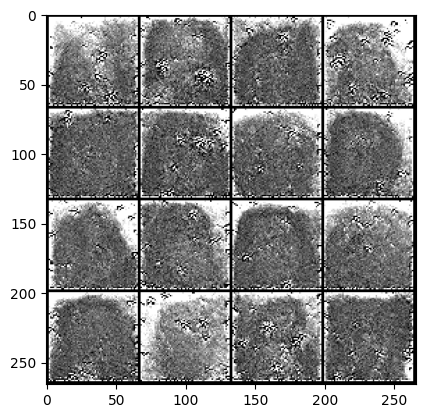

In [10]:
plt.imshow(torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0))